## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


### Load packages

In [64]:
%load_ext autoreload
%autoreload 2

import os
import dask
import numpy as np
import geopandas as gpd

import datacube
import odc.geo.xr
from odc.geo.geom import Geometry
from odc.algo import (
    xr_geomedian,
    xr_quantile,
    int_geomedian,
    enum_to_bool,
    erase_bad,
    keep_good_only,
)

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides
from intertidal.utils import load_config
from intertidal.elevation import extract_geom


def glint_angle(solar_azimuth, solar_zenith, view_azimuth, view_zenith):
    """
    Calculates glint angles for each pixel in a satellite
    image based on the relationship between the solar and
    sensor zenith and azimuth viewing angles at the moment
    the image was acquired.

    Glint angle is considered a predictor of sunglint over
    water; small glint angles (e.g. < 20 degrees) are associated
    with a high probability of sunglint due to the viewing
    angle of the sensor being aligned with the specular
    reflectance of the sun from the water's surface.

    Based on code from https://towardsdatascience.com/how-to-implement-
    sunglint-detection-for-sentinel-2-images-in-python-using-metadata-
    info-155e683d50
    """

    # Convert angle arrays to radians
    solar_zenith_rad = np.deg2rad(solar_zenith)
    solar_azimuth_rad = np.deg2rad(solar_azimuth)
    view_zenith_rad = np.deg2rad(view_zenith)
    view_azimuth_rad = np.deg2rad(view_azimuth)

    # Calculate sunglint angle
    phi = solar_azimuth_rad - view_azimuth_rad
    glint_angle = np.cos(view_zenith_rad) * np.cos(solar_zenith_rad) - np.sin(
        view_zenith_rad
    ) * np.sin(solar_zenith_rad) * np.cos(phi)

    # Convert to degrees
    glint_array = np.degrees(np.arccos(glint_angle))

    return glint_array

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [3]:
dc = datacube.Datacube(app='DEA Composites')

#### Set study area

##### Option 1: load study area from 32 km tile GridSpec

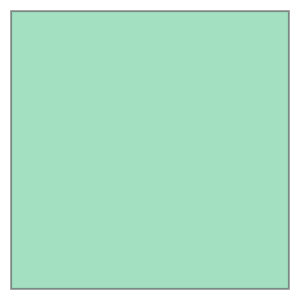

In [121]:
# Set study area (e.g. tile ID in form 'x143y87')
study_area = "x143y56"  # "x78y129"
geom = extract_geom(study_area)
geom

##### Option 2: load study area from vector file

In [70]:
# # Set study area to load from file
# study_area = "pointstuart"

# # Read file, select study area and convert to geom
# studyarea_gdf = gpd.read_file(
#     "data/raw/intertidal_development_polygons.geojson"
# ).set_index("id")
# geom = Geometry(studyarea_gdf.loc[study_area].geometry, crs=studyarea_gdf.crs)
# geom

##### Option 3: load study area using interactive map

In [68]:
# # Set study area name for outputs
# study_area = "testing"

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
# geom

## Load data

In [134]:
spectral_bands = [
    "nbart_blue",
    "nbart_green",
    "nbart_red",
    "nbart_nir_1",
    "nbart_nir_2",
    "nbart_swir_2",
    "nbart_swir_3",
]
sunglint_bands = [
    "solar_zenith",
    "solar_azimuth",
    "satellite_azimuth",
    "satellite_view",
]
masking_bands = ["oa_s2cloudless_mask", "oa_nbart_contiguity"]


ds = dc.load(
    product=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    time=("2019", "2021"),
    geopolygon=geom,
    measurements=spectral_bands + sunglint_bands + masking_bands,
    output_crs="EPSG:3577",
    group_by="solar_day",
    # dask_chunks={"x": 2048, "y": 2048},
    dask_chunks={"x": 1600, "y": 1600},
    resampling={
        "*": "cubic",
        "oa_s2cloudless_mask": "nearest",
        "oa_nbart_contiguity": "nearest",
    },
    resolution=(-10, 10),
    gqa_iterative_mean_xy=(0, 1),
)
ds

<xarray.Dataset>
Dimensions:              (time: 311, y: 3200, x: 3200)
Coordinates:
  * time                 (time) datetime64[ns] 2019-01-01T23:55:33.982000 ......
  * y                    (y) float64 -3.648e+06 -3.648e+06 ... -3.68e+06
  * x                    (x) float64 1.888e+06 1.888e+06 ... 1.92e+06 1.92e+06
    spatial_ref          int32 3577
Data variables: (12/13)
    nbart_blue           (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_green          (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_red            (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_nir_1          (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_nir_2          (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    nbart_swir_2         (time, y, x) int16 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    ...                   ...
    solar_zenith         (time, y, x) float32 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    solar_azimuth        (time, y, x) float32 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    satellite_azimuth    (time, y, x) float32 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    satellite_view       (time, y, x) float32 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    oa_s2cloudless_mask  (time, y, x) uint8 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
    oa_nbart_contiguity  (time, y, x) uint8 dask.array<chunksize=(1, 1600, 1600), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [135]:
# Create cloud mask, treating nodata and clouds as bad pixels
cloud_mask = enum_to_bool(mask=ds.oa_s2cloudless_mask, categories=["nodata", "cloud"])

# Apply cloud mask to data in spectral and sunglint bands
ds_cloudmasked = erase_bad(x=ds[spectral_bands + sunglint_bands], where=cloud_mask)

In [144]:
# Model tides into every pixel in the three-dimensional (x by y by time) satellite dataset
tides_highres, tides_lowres = pixel_tides(ds_cloudmasked, resample=True)

# Calculate a 2D (x by y) tide threshold
min_thresh = (
    tides_lowres.quantile(q=0.2, dim="time")
    .odc.assign_crs(ds.odc.geobox.crs)
    .odc.reproject(ds.odc.geobox, resampling="bilinear")
    .drop("quantile")
)

In [145]:
# Apply threshold to keep only pixels with tides less than tide threshold
tide_mask = tides_highres <= min_thresh

# Convert tide mask to Dask array so we can use it in `keep_good_only`
tide_mask_dask = tide_mask.copy(  # Copies the shape and coords, but not the data
    data=dask.array.from_array(
        tide_mask.values, chunks=ds_cloudmasked.nbart_red.data.chunks
    )
)

# Mask out pixels outside of selected tides, and filter to timesteps
# that have at least some valid data
ds_low = keep_good_only(x=ds_cloudmasked, where=tide_mask_dask).sel(
    time=tide_mask.any(dim=["x", "y"])
)

In [146]:
# Calculate sunglint
glint_array = glint_angle(
    solar_azimuth=ds_low.solar_azimuth,
    solar_zenith=ds_low.solar_zenith,
    view_azimuth=ds_low.satellite_azimuth,
    view_zenith=ds_low.satellite_view,
)

# Mask out sunglinted pixels
output_name = "glint_filter_20"
glint_mask = glint_array > 20
ds_noglint = keep_good_only(x=ds_low[spectral_bands], where=glint_mask)

# # Don't mask out glinted pixels
# output_name = "none"
# ds_noglint = ds_low[spectral_bands]


In [147]:
# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Calculate geomedian
ds_low_geomedian = int_geomedian(ds=ds_noglint, maxiters=10, num_threads=os.cpu_count() - 2)

# Load into memory and close client
ds_low_geomedian.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33879/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33879/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36235,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/33879/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:46803,Total threads: 31
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/41633/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:38207,


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


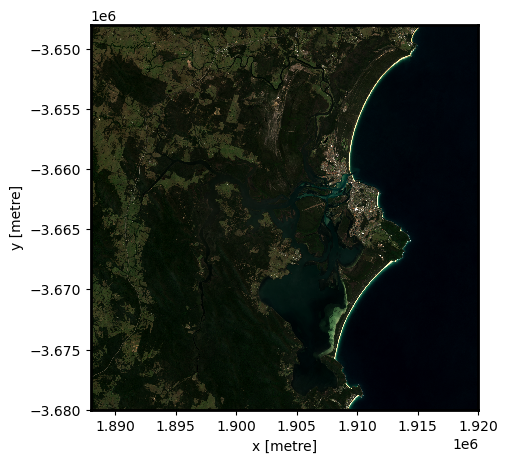

In [148]:
ds_low_geomedian.odc.to_rgba(vmin=200, vmax=2800).plot.imshow(size=5, aspect=1)

In [149]:
ds_low_geomedian.to_array().odc.write_cog(f'{study_area}_geomedian_20_{output_name}.tif', overwrite=True, nodata=-999)

PosixPath('x143y56_geomedian_80_glint_filter_20.tif')